In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 37
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 300
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
final = pd.read_csv("/app/_data/labels_nocall/nocall_predictions.csv")
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

In [4]:
all_audio_init = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio_init.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)

all_audio.shape

(65128, 24)

# dict_birds and weights

In [5]:
dict_birds, all_audio = make_dict_birds(all_audio)

In [6]:
len(dict_birds)

398

In [7]:
# os.mkdir("/app/_data/models/from_nocall/Eff2_1/")

In [8]:
file_json = open("/app/_data/models/from_nocall/Eff2_2/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [9]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

In [10]:
all_audio = all_audio[all_audio["rating"] >= 3]

## calls

In [11]:
drop_list_final = final[(final["bird"] == 1) & (final["nocall"] == 1)][
    "row_id"
].tolist()

In [12]:
final = final.query("row_id not in @drop_list_final")
final = final.query("bird == 1")


In [13]:
final = final.merge(
    all_audio[["filename", "primary_label", "class_weights", 'duration']], on="filename", how="left"
)

In [14]:
final = final.dropna(axis=0)
final = final.drop(['nocall', 'bird'], axis=1)

In [15]:
dict_w = pd.DataFrame((1/final['filename'].value_counts()))
dict_w.columns=['weights']
dict_w['filename'] = dict_w.index

In [16]:
final = final.merge(dict_w, on='filename', how='left')

In [17]:
final_sample = final.sample(1000000, weights="weights", random_state=SEED)
final_sample = final_sample.sample(300000, weights="class_weights", random_state=SEED)

In [18]:
final_sample['primary_label'].value_counts()

normoc     1435
bncfly     1336
houwre     1323
houspa     1292
spotow     1267
           ... 
hofwoo1     133
crfpar      118
whcpar      109
stvhum2      50
wegspa1      49
Name: primary_label, Length: 397, dtype: int64

In [19]:
final_sample['filename'].value_counts()

XC152396.ogg    38
XC320750.ogg    38
XC429777.ogg    36
XC153986.ogg    36
XC565865.ogg    36
                ..
XC333640.ogg     1
XC395126.ogg     1
XC139095.ogg     1
XC192706.ogg     1
XC568349.ogg     1
Name: filename, Length: 49196, dtype: int64

In [20]:
final_sample

,row_id,filename,end_sec,primary_label,class_weights,duration,weights
2124045,XC350798_56_0,XC350798.ogg,56.0,whbnut,0.003155,108.448437,0.009615
1488594,XC193766_87_0,XC193766.ogg,87.0,pasfly,0.006369,215.498250,0.005618
1732840,XC588548_19_0,XC588548.ogg,19.0,rudtur,0.007937,38.806000,0.031250
1803325,XC393354_6_0,XC393354.ogg,6.0,smbani,0.006250,11.899875,0.142857
2286913,XC278367_19_0,XC278367.ogg,19.0,yelwar,0.008696,34.051719,0.037037
...,...,...,...,...,...,...,...
1206992,XC312979_15_0,XC312979.ogg,15.0,lesvio1,0.006410,41.029000,0.038462
257292,XC133081_12_0,XC133081.ogg,12.0,bknsti,0.007353,22.557844,0.055556
10261,XC616749_19_0,XC616749.ogg,19.0,acowoo,0.005263,24.781000,0.058824
6309,XC245856_31_0,XC245856.ogg,31.0,acowoo,0.005263,32.458250,0.038462


In [21]:
final_sample = final_sample[
    ["row_id", "filename", "end_sec", "primary_label", "class_weights"]
].merge(
    all_audio[
        [
            "filename",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
        ]
    ],
    on="filename",
    how="left",
)

In [22]:
final_sample = final_sample.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [23]:
final_sample["primary_label"].value_counts()

normoc     1435
bncfly     1336
houwre     1323
houspa     1292
spotow     1267
           ... 
hofwoo1     133
crfpar      118
whcpar      109
stvhum2      50
wegspa1      49
Name: primary_label, Length: 397, dtype: int64

# nocall

In [24]:
nocall = nocall.drop_duplicates()

In [25]:
nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

In [26]:
nocall = nocall[~nocall['file_path'].str.contains('train_soundscapes')].reset_index(drop=True)

In [27]:
soundscapes_nocall =all_audio[all_audio['file_path'].str.contains('train_soundscapes')]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall['primary_label']=='nocall']

In [28]:
dict_w = (1/nocall['filename'].value_counts()).to_dict()
nocall['weights'] = nocall['filename'].replace(dict_w)

In [29]:
nocall_sample = nocall.sample(1200, random_state=SEED,  weights='weights')

In [30]:
nocall_sample['filename'].value_counts()

XC283162.ogg    15
XC256594.ogg    13
XC144701.ogg    13
XC318014.ogg    12
XC483212.ogg    11
                ..
XC187408.ogg     1
XC617299.ogg     1
XC259210.ogg     1
XC132192.ogg     1
XC564545.ogg     1
Name: filename, Length: 191, dtype: int64

In [31]:
nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            'class_weights'
        ]
    ],
    on="filename",
    how="left",
)

In [32]:
nocall_sample = nocall_sample[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]
soundscapes_nocall = soundscapes_nocall[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]

In [33]:
soundscapes_nocall['duration']=600

In [34]:
all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

In [35]:
all_nocall["label_id"] = dict_birds["nocall"]
all_nocall["secondary_labels_id"] = np.nan
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [36]:
all_nocall.isna().sum()

filename                  0
row_id                    0
start_sec                 0
end_sec                   0
file_path                 0
duration                  0
rating                    0
year                      0
sin_month                 0
cos_month                 0
sin_longitude             0
cos_longitude             0
latitude                  0
norm_latitude             0
class_weights             0
label_id                  0
secondary_labels_id    2729
dtype: int64

In [37]:
all_nocall['year'].describe()

count    2729.000000
mean     2015.933675
std         4.758963
min      1989.000000
25%      2015.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

# concat

In [38]:
final_audio = (
    pd.concat(
        [final_sample, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

(302729, 19)

In [39]:
final_audio["primary_label"].value_counts().tail(20)

grnher     361
amewig     346
buwtea     346
flrtan1    341
nrwswa     328
higmot1    316
sander     306
rebsap     286
bucmot2    247
grhcha1    243
rthhum     221
rehbar1    217
gretin1    196
heptan     167
runwre1    148
hofwoo1    133
crfpar     118
whcpar     109
stvhum2     50
wegspa1     49
Name: primary_label, dtype: int64

#  upsampling


In [40]:
rare_birds = list(final_audio["primary_label"].value_counts().tail(20).index.values)

In [41]:
df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
    all_audio.query("primary_label ==@bird")["filename"].unique().tolist())
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array)
    df = pd.concat([df, intervals], axis=0)

df

,end_sec,class_weights,filename
XC109031_5_0,5.00,0.017241,XC109031.ogg
XC109031_6_15,6.15,0.017241,XC109031.ogg
XC109031_7_3,7.30,0.017241,XC109031.ogg
XC109031_8_45,8.45,0.017241,XC109031.ogg
XC109031_9_6,9.60,0.017241,XC109031.ogg
...,...,...,...
XC433788_36_52,36.52,0.100000,XC433788.ogg
XC433788_36_68,36.68,0.100000,XC433788.ogg
XC433788_36_84,36.84,0.100000,XC433788.ogg
XC433788_37_0,37.00,0.100000,XC433788.ogg


In [42]:
df['filename'].unique().shape

(499,)

In [43]:
df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

In [44]:
df['primary_label'].unique().shape

(20,)

In [45]:
final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

(313995, 21)

baleag     464
solsan     462
belkin1    459
comgol     446
rugdov     433
pavpig2    426
brwpar1    421
tropew1    421
semplo     420
blctan1    411
scrtan1    407
leasan     395
whimbr     393
sthwoo1    393
commer     391
norsho     390
wooduc     376
lotduc     373
cacgoo1    370
goowoo1    363
Name: primary_label, dtype: int64

In [46]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [47]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 220

In [48]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [49]:
# shutil.rmtree('/app/_data/npy/short_mels_224_uint8/', ignore_errors=True)

In [50]:
gen_train = MEL_Gen(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
)

In [51]:
a = gen_train.__getitem__(0)

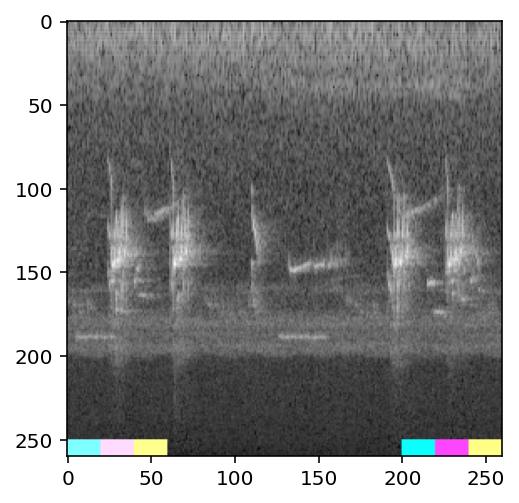

In [52]:
plt.imshow(a[0][0])

# model

In [53]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [54]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/from_nocall/Eff2_2/Eff2_2.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_2_nc/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/from_nocall/Eff2_2/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [ ]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

Epoch 55/100
   1/1141 [..............................] - ETA: 0s - loss: 0.0030 - acc: 0.9727 - recall: 0.6098 - precision: 0.9892 - f1_score: 0.8084WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1141/1141 [==============================] - ETA: 0s - loss: 0.0026 - acc: 0.9775 - recall: 0.6020 - precision: 0.9905 - f1_score: 0.8173
Epoch 00055: val_f1_score improved from -inf to 0.81347, saving model to /app/_data/models/from_nocall/Eff2_2/Eff2_2.h5
1141/1141 [==============================] - 632s 554ms/step - loss: 0.0026 - acc: 0.9775 - recall: 0.6020 - precision: 0.9905 - f1_score: 0.8173 - val_loss: 0.0026 - val_acc: 0.9744 - val_recall: 0.6684 - val_precision: 0.9868 - val_f1_score: 0.8135
Epoch 56/100
1141/1141 [==============================] - ETA: 